In [2]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = ""
os.environ["JAX_PLATFORMS"] = "cpu"
os.environ["JAX_ENABLE_X64"] = "True"


In [3]:
from bpd.io import load_dataset

import matplotlib.pyplot as plt

import numpy as np 

import arviz

In [4]:
ds = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp22_42/full_samples_42.npz")

In [5]:
ds2 = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/exp22_42/convergence_results_42.npz")

In [6]:
ds.keys()

dict_keys(['truth', 'hyper', 'samples'])

In [7]:
ds2.keys()

dict_keys(['ess', 'rhat'])

In [8]:
ds2['rhat'].keys()

dict_keys(['lhlr', 'lf', 'e1', 'dy', 'dx', 'e2'])

In [10]:
rhats_dict = ds2['rhat']
for p in rhats_dict:
    rhat = rhats_dict[p]
    outliers = (rhat < 0.99) | (rhat > 1.05)
    n_outliers = sum(outliers)
    print(f"Number of R-hat outliers for {p}: {n_outliers}")

Number of R-hat outliers for lhlr: 159
Number of R-hat outliers for lf: 6
Number of R-hat outliers for e1: 154
Number of R-hat outliers for dy: 4
Number of R-hat outliers for dx: 2
Number of R-hat outliers for e2: 152


In [11]:
# get mask based on rhat for all
rhats_dict = ds2['rhat']
mask = np.ones_like(ds['truth']['f']).astype(bool)
for p in rhats_dict:
    rhat = rhats_dict[p]
    _mask = (rhat < 0.99) | (rhat > 1.05)
    mask = mask & ~_mask

In [12]:
sum(~mask)

np.int64(162)

In [17]:
f_all = np.log10(ds['truth']['f'])

In [ ]:
f_bad = f_all[~mask]

In [14]:
f_all.shape, f_bad.shape

((8000,), (162,))

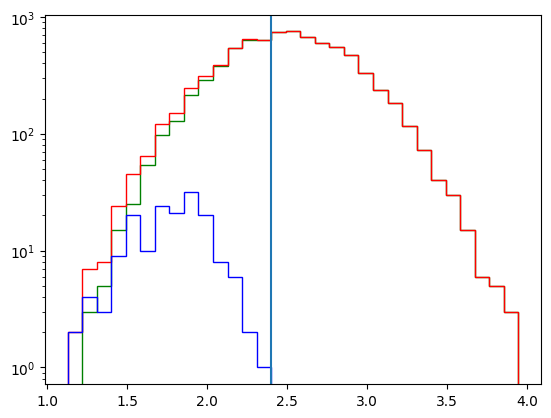

In [15]:
n1, bins, _ = plt.hist(f_all, histtype='step', color='r', bins=31) 
n2, bins, _ = plt.hist(f_bad, histtype='step', bins=bins, color='b') 
plt.stairs(n1 - n2, bins, color='g')

plt.yscale('log')
plt.axvline(2.4)

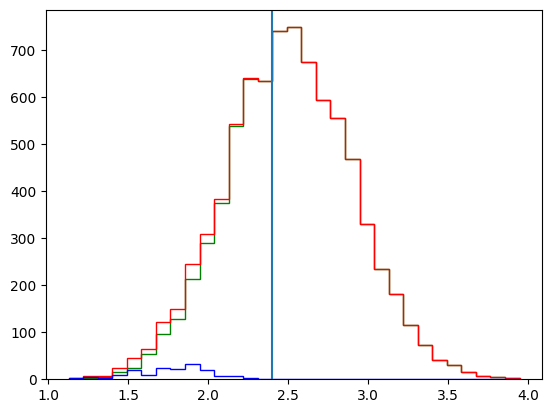

In [16]:
n1, bins, _ = plt.hist(f_all, histtype='step', color='r', bins=31)
n2, bins, _ = plt.hist(f_bad, histtype='step', bins=bins, color='b') 
plt.stairs(n1 - n2, bins, color='g')

# plt.yscale('log')
plt.axvline(2.4)

## Truncated Gaussian Centered at 2.5

In [18]:
from scipy.stats import truncnorm


loc, scale = 2.5, 0.4
a = (2.45 - loc) / scale  # wiggle room (not 2.4)
b = np.inf

rv = truncnorm(a, b, loc=loc, scale=scale)

In [19]:
import numpy as np
rng = np.random.default_rng(12349)
rvs= rv.rvs(size=8000, random_state=rng)
rvs.shape

(8000,)

In [ ]:
jax.random.key(52)

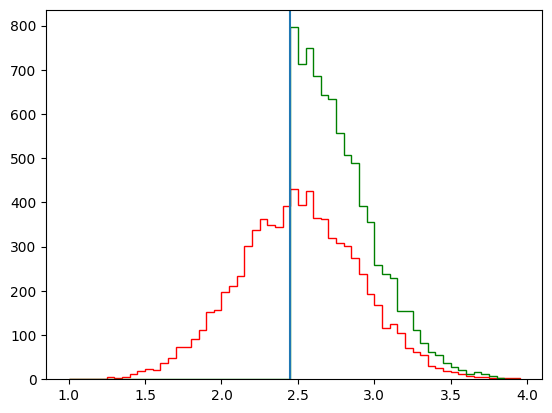

In [20]:
bins  = np.arange(1, 4, 0.05)
_, _, _ = plt.hist(f_all, histtype='step', color='r', bins=bins) 

plt.hist(rv.rvs(size=8000), histtype='step', color='g', bins=bins)
plt.axvline(2.45)

In [21]:
np.arange(1, 4, 0.05)

array([1.  , 1.05, 1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 ,
       1.55, 1.6 , 1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  , 2.05,
       2.1 , 2.15, 2.2 , 2.25, 2.3 , 2.35, 2.4 , 2.45, 2.5 , 2.55, 2.6 ,
       2.65, 2.7 , 2.75, 2.8 , 2.85, 2.9 , 2.95, 3.  , 3.05, 3.1 , 3.15,
       3.2 , 3.25, 3.3 , 3.35, 3.4 , 3.45, 3.5 , 3.55, 3.6 , 3.65, 3.7 ,
       3.75, 3.8 , 3.85, 3.9 , 3.95])

In [63]:
import jax
key = jax.random.key(52)

In [64]:
k1, k2 = jax.random.split(key)

In [72]:
rng = np.random.default_rng(np.array(jax.random.key_data(k1)))

In [74]:
rng.normal()

1.4702537503615625

In [62]:
k1, k2

(Array((), dtype=key<fry>) overlaying:
 [1495156955 3391349020],
 Array((), dtype=key<fry>) overlaying:
 [4243728637 2773183530])

In [ ]:
k1.

### Check custom function works too

In [33]:
import jax
import numpy as np 
import jax.numpy as jnp

In [26]:
seed = 39
key = jax.random.key(seed)

In [27]:
from bpd.sample import sample_galaxy_params_trunc
params = sample_galaxy_params_trunc(key, mean_logflux=2.5, sigma_logflux=0.4, min_logflux=2.45, mean_loghlr=-0.4, sigma_loghlr=0.05, shape_noise=0.2, n=8000) 

In [28]:
f_all = np.log10(ds['truth']['f'])

In [29]:
params['lf'].shape, f_all.shape

((8000,), (8000,))

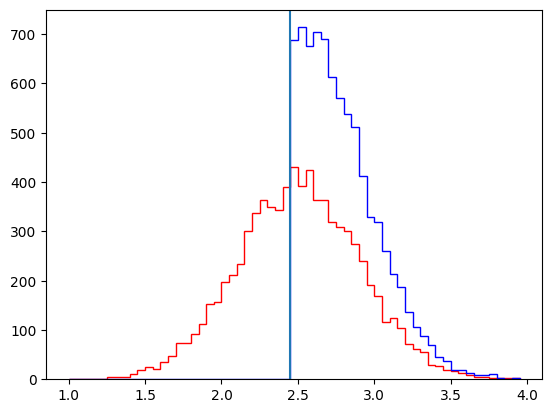

In [30]:
bins  = np.arange(1, 4, 0.05)
_, _, _ = plt.hist(f_all, histtype='step', color='r', bins=bins) 

plt.hist(params['lf'], histtype='step', color='b', bins=bins)
plt.axvline(2.45)

In [36]:
jnp.array(np.zeros(10,))

Array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float64)

## Arviz amd ESS

In [14]:
from tqdm import tqdm


In [15]:
samples = ds['samples']

In [16]:
samples.keys()

dict_keys(['lhlr', 'lf', 'e1', 'dy', 'dx', 'e2'])

In [17]:
samples['lf'].shape

(8000, 4, 500)

In [28]:
ess_dict = {} 

for ii in tqdm(range(8000)): 
    params = {k:v[ii] for k,v in samples.items()}
    value = arviz.ess(params)

    for k in samples:
        kval = value[k].data.item()
        if k not in ess_dict:
            ess_dict[k] = [kval]
        else: 
            ess_dict[k].append(kval)



100%|██████████| 8000/8000 [00:49<00:00, 160.02it/s]


NameError: name 'jnp' is not defined

In [29]:
_ess_dict = {k:np.array(v) for k,v in ess_dict.items()}

In [47]:
sum(np.isnan(_ess_dict['lf']))

np.int64(149)

In [37]:
_ess_dict['e1']

array([  15.64537681, 1106.88490672, 2012.25427973, ..., 1907.07492896,
       1892.20303879, 1748.68487957], shape=(8000,))

(array([ 158.,    6.,    7.,   10.,   22.,   28.,   46.,   82.,  107.,
         153.,  311.,  534.,  688.,  991., 1184., 1193.,  918.,  687.,
         420.,  239.,  121.,   60.,   20.,   12.,    3.]),
 array([   4.06504065,  127.01438262,  249.9637246 ,  372.91306657,
         495.86240855,  618.81175052,  741.7610925 ,  864.71043447,
         987.65977644, 1110.60911842, 1233.55846039, 1356.50780237,
        1479.45714434, 1602.40648632, 1725.35582829, 1848.30517026,
        1971.25451224, 2094.20385421, 2217.15319619, 2340.10253816,
        2463.05188013, 2586.00122211, 2708.95056408, 2831.89990606,
        2954.84924803, 3077.79859001]),
 <BarContainer object of 25 artists>)

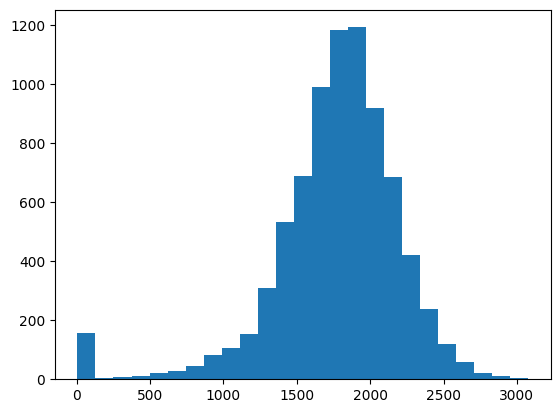

In [33]:
plt.hist(_ess_dict['e1'], bins=25)

In [48]:
# outliers and compare with the rhat ones 
mask = np.ones_like(ds['truth']['f']).astype(bool)
for k in _ess_dict: 
    new_mask = (_ess_dict[k] / 2000 < 0.1) | np.isnan(_ess_dict[k])
    mask = mask & (~new_mask)
sum(mask)

np.int64(7813)

In [49]:
f_all = np.log10(ds['truth']['f'])
f_bad = f_all[~mask]

In [50]:
f_all.shape, f_bad.shape

((8000,), (187,))

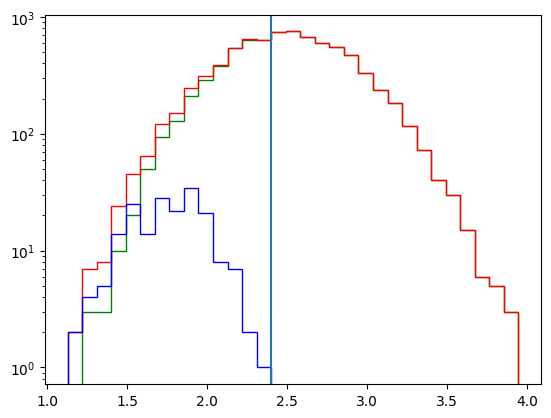

In [51]:
n1, bins, _ = plt.hist(f_all, histtype='step', color='r', bins=31) 
n2, bins, _ = plt.hist(f_bad, histtype='step', bins=bins, color='b') 
plt.stairs(n1 - n2, bins, color='g')

plt.yscale('log')
plt.axvline(2.4)